## Seismic Data Analysis Notebook ##

Data is downloaded as *.mseed in Download_Data.ipynb




### Basic Signal Processing ###

In [11]:
from obspy import read, UTCDateTime
import os
import matplotlib.pyplot as plt

# Directory where daily .mseed files are stored
input_directory = "/home/jen/snap/MLGEO2024_Geldingadalir/notebooks/HVUWB_analysis/data/raw"

output_directory = "/home/jen/snap/MLGEO2024_Geldingadalir/notebooks/HVUWB_analysis/data/clean/"
os.makedirs(output_directory, exist_ok=True)

plot_directory = "/home/jen/snap/MLGEO2024_Geldingadalir/notebooks/HVUWB_analysis/data/plots/"
os.makedirs(plot_directory, exist_ok=True)

# List all files in the input directory that match the pattern "*_hvuwb.mseed"
mseed_files = sorted([f for f in os.listdir(input_directory) if f.endswith("_hvuwb.mseed")])

MAX_TARGET_FREQUENCY = 4   
TARGET_SAMPLING_RATE = 8

# Loop through each .mseed file found in the directory
for file_name in mseed_files:
    # Construct the full file path
    file_path = os.path.join(input_directory, file_name)
    
    try:
        # Load the data from the .mseed file
        st = read(file_path)
        #print(f"Processing data for file {file_name}")
        
        # Detrend the signal to remove linear trends
        st.detrend("linear")
        #print(f'completed detrend for {file_name}')
        st.detrend("demean")
        #print(f'completed demean for {file_name}')
        
        # Filter the signal with a bandpass filter?? (e.g., 1–4 Hz)
        # st_filtered = st.copy()
        # st_filtered.filter("bandpass", freqmin=1, freqmax=4)
        
        # Filter the signal with a lowpass filter (e.g., 1–4 Hz)
        st_filtered = st.copy()
        st_filtered.filter("lowpass", freq=MAX_TARGET_FREQUENCY, zerophase=True)
        #print(f'completed lowpass filter for {file_name}')
        
        # Downsample
        factor_to_decimate = int(st_filtered[0].stats.sampling_rate / TARGET_SAMPLING_RATE)
        st_filtered.decimate(factor=factor_to_decimate, strict_length=False)
        #print(f'completed decimate for {file_name}')
        
        # Trim off the tapered edges
        st_filtered.trim(UTCDateTime(st_filtered[0].stats.starttime) + 10, UTCDateTime(st_filtered[0].stats.endtime) - 10)
        #print(f'completed trim for {file_name}')

        # Normalize the signal (scale between 0 and 1)
        #st_filtered.normalize()

        # 4. Save processed data to a new .mseed file
        output_file = os.path.join(output_directory, f"{file_name.replace('.mseed', '')}_processed.mseed")
        st_filtered.write(output_file, format="MSEED")
        print(f"Saved processed data for {file_name}")

        # 5. Plotting the processed signal for visualization
        # plt.figure(figsize=(10, 4))
        # for tr in st_filtered:
        #     plt.plot(tr.times("matplotlib"), tr.data, label=tr.id)
        # plt.title(f"Filtered and Normalized Seismic Data - {file_name}")
        # plt.xlabel("Time")
        # plt.ylabel("Amplitude")
        # plt.legend()
        
        # # Save the plot
        # plot_file = os.path.join(plot_directory, f"{file_name.replace('.mseed', '')}_processed.png")
        # plt.savefig(plot_file)
        # print(f"Saved plot for {file_name}")
        # plt.close()  # Close the figure to free memory
        
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")


completed detrend for 10_hvuwb.mseed
completed demean for 10_hvuwb.mseed
completed lowpass filter for 10_hvuwb.mseed
completed decimate for 10_hvuwb.mseed
completed trim for 10_hvuwb.mseed
Saved processed data for 10_hvuwb.mseed


/home/jen/anaconda3/envs/mlgeo/lib/python3.11/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


completed detrend for 11_hvuwb.mseed
completed demean for 11_hvuwb.mseed
completed lowpass filter for 11_hvuwb.mseed
completed decimate for 11_hvuwb.mseed
completed trim for 11_hvuwb.mseed
Saved processed data for 11_hvuwb.mseed
completed detrend for 12_hvuwb.mseed
completed demean for 12_hvuwb.mseed
completed lowpass filter for 12_hvuwb.mseed
completed decimate for 12_hvuwb.mseed
completed trim for 12_hvuwb.mseed
Saved processed data for 12_hvuwb.mseed
completed detrend for 13_hvuwb.mseed
completed demean for 13_hvuwb.mseed
completed lowpass filter for 13_hvuwb.mseed
completed decimate for 13_hvuwb.mseed
completed trim for 13_hvuwb.mseed
Saved processed data for 13_hvuwb.mseed
completed detrend for 14_hvuwb.mseed
completed demean for 14_hvuwb.mseed
completed lowpass filter for 14_hvuwb.mseed
completed decimate for 14_hvuwb.mseed
completed trim for 14_hvuwb.mseed
Saved processed data for 14_hvuwb.mseed
completed detrend for 15_hvuwb.mseed
completed demean for 15_hvuwb.mseed
completed l

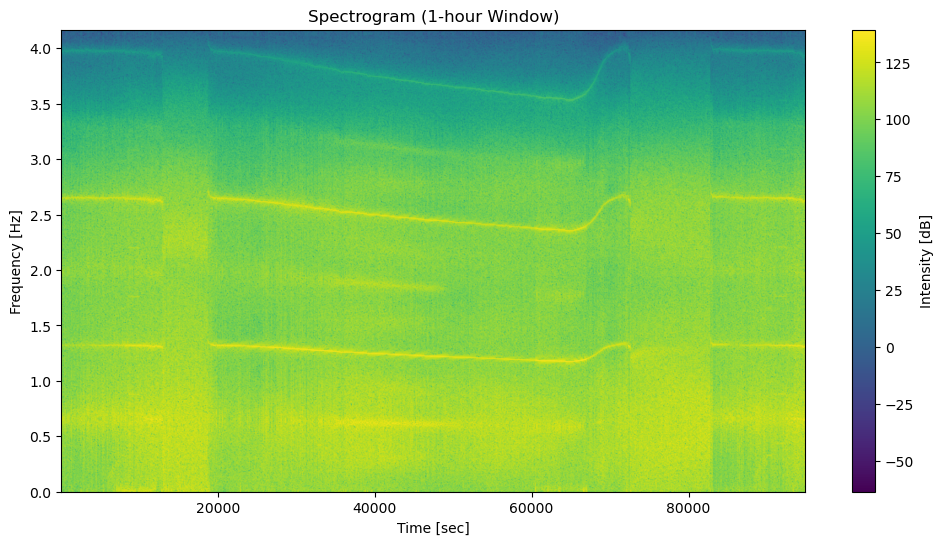

In [14]:

## Step 3: Frequency Analysis with Short-Time Fourier Transform (STFT)

from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import numpy as np

# Select a single trace from the filtered data
tr = st_filtered[0]

# Compute the spectrogram (STFT) with desired segment length
f, t, Sxx = spectrogram(tr.data, fs=tr.stats.sampling_rate, nperseg=1024)

# Plot the spectrogram
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram (1-hour Window)")
plt.colorbar(label="Intensity [dB]")
plt.show()


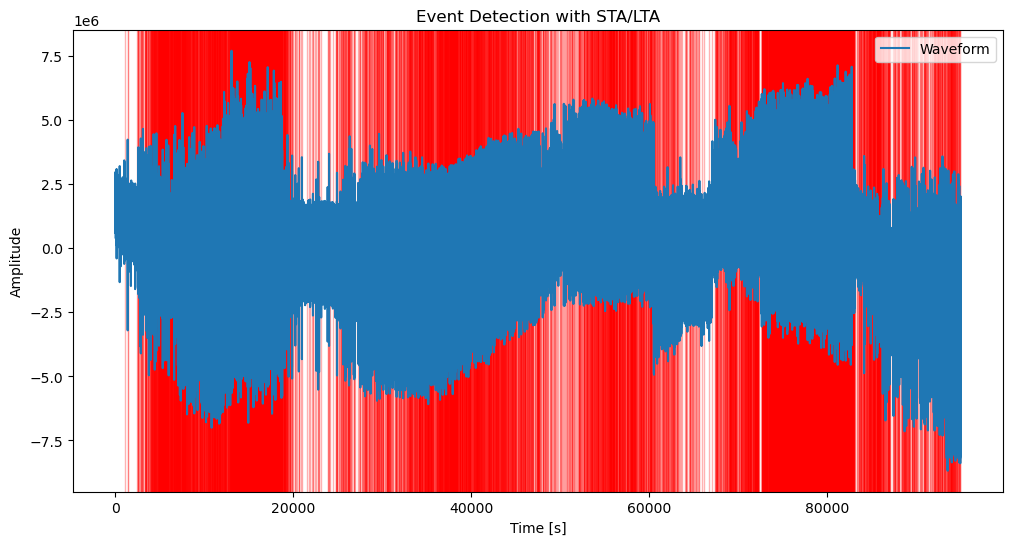

Amplitude Statistics: {'mean': 182.60769425891928, 'median': 64259.145828761684, 'std_dev': 1488277.2549073435, 'max_amplitude': 7715431.860376557}


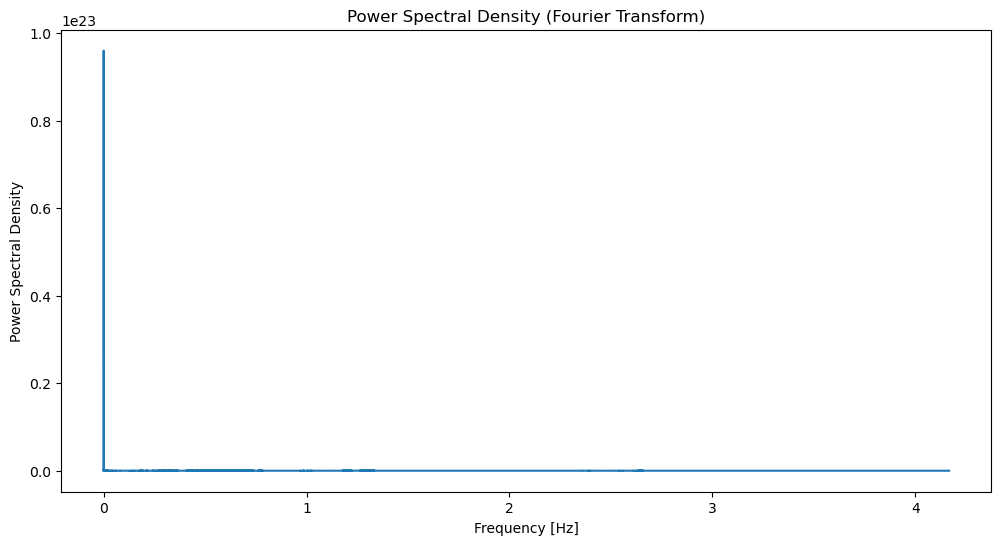

In [15]:


## Step 4: Detect Seismic Events (Peak Detection)
# Example STA/LTA (Short-Term Average / Long-Term Average) detection
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# Apply STA/LTA algorithm
sta = 1   # short time window in seconds
lta = 10  # long time window in seconds
sampling_rate = tr.stats.sampling_rate
cft = classic_sta_lta(tr.data, int(sta * sampling_rate), int(lta * sampling_rate))

# Set thresholds for event detection
on_threshold = 2.5
off_threshold = 1.0
triggers = trigger_onset(cft, on_threshold, off_threshold)

# Plot results with detected events
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(tr.times(), tr.data, label="Waveform")
for trigger in triggers:
    ax.axvspan(tr.times()[trigger[0]], tr.times()[trigger[1]], color="red", alpha=0.3)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.set_title("Event Detection with STA/LTA")
plt.legend()
plt.show()

## Step 5: Basic Statistical Analysis of Amplitude

# Calculate basic statistics on the raw signal
amplitude_stats = {
    "mean": np.mean(tr.data),
    "median": np.median(tr.data),
    "std_dev": np.std(tr.data),
    "max_amplitude": np.max(tr.data)
}
print("Amplitude Statistics:", amplitude_stats)

## Step 6: Frequency Analysis (Fourier Transform and Power Spectral Density)

# Compute Fourier Transform
fft_values = np.fft.fft(tr.data)
fft_frequencies = np.fft.fftfreq(len(fft_values), d=1 / sampling_rate)

# Plot the power spectral density
plt.figure(figsize=(12, 6))
plt.plot(fft_frequencies[:len(fft_values) // 2], np.abs(fft_values[:len(fft_values) // 2])**2)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density (Fourier Transform)")
plt.show()
